# Customers Segmentation for a Credit Card Company

1. [Introduction](#intro)
2. [Data Exploration](#explore)  
    2.1 [Numeric Features](#numeric-features)  
    2.2 [Categorical Features](#categorical-features)  
    2.3 [Standardization](#standard)
3. [Model Building](#model-build)
4. [Result Interpretation](#interpret)
5. [Application](#application)

# Introduction<a id='intro'></a>
&emsp;In this scenario guided by Dataquest, I will be using a dataset from a fictitious credit card company to segment customers into particular number of groups using K-Means algorithm for marketing purposes.

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
mpl.style.use('tableau-colorblind10')
%matplotlib inline

# Data Exploration<a id='explore'></a>

In [2]:
# Import dataset
customers = pd.read_csv("https://raw.githubusercontent.com/moscmh/creditcard/main/customer_segmentation.csv")

In [3]:
print(f"Records: {customers.shape[0]}\nFeatures: {customers.shape[1]}")
customers.head(3)

Records: 10127
Features: 14


,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000


* Note that the total_relationship_count refers to the number of times the customer contacted the company.

In [4]:
# Missing values
customers.isna().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

## Numeric Features<a id='numeric-features'></a>

In [5]:
# Numeric features
numeric = list(customers.loc[:,~(customers.dtypes==object)].columns)
numeric.remove("customer_id")

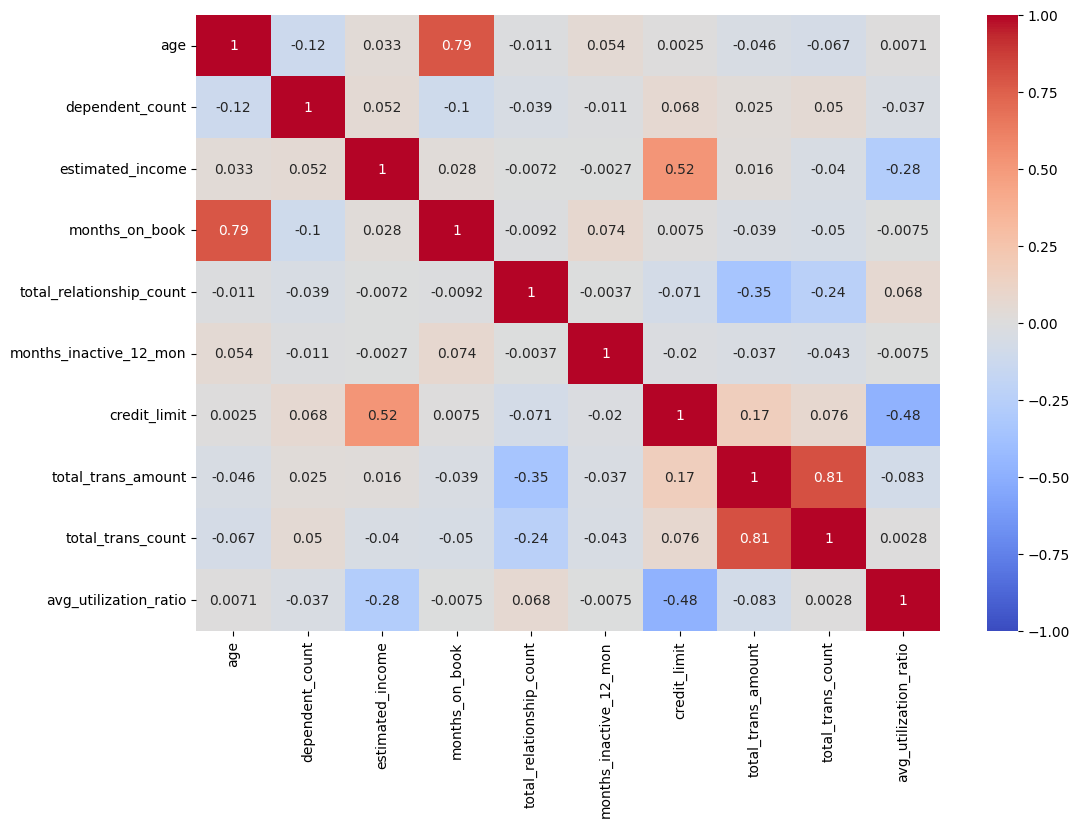

In [6]:
# Correlations among features
cor = customers[numeric].corr()
plt.figure(figsize=(12,8))
sns.heatmap(cor, cmap='coolwarm', annot=True, vmin=-1, vmax=1, center=0)
plt.show()

&emsp;There are some moderately strong correlations among some of the features. Many of them are reasonable such as  
* Age & Months on Book,  
* Credit Limit & Estimated Income,  
* Total Transaction Amount & Total Number of Transaction etc.  

&emsp;While something a bit peculiar to note are the the negative relationship between  
* Total Relationship Count & Total Transaction Amount,  
* Total Relationship Count & Total Number of Transaction,  
* Credit Limit & Average Utilization Ratio, and  
* Estimated Income & Average Utilization Ratio.

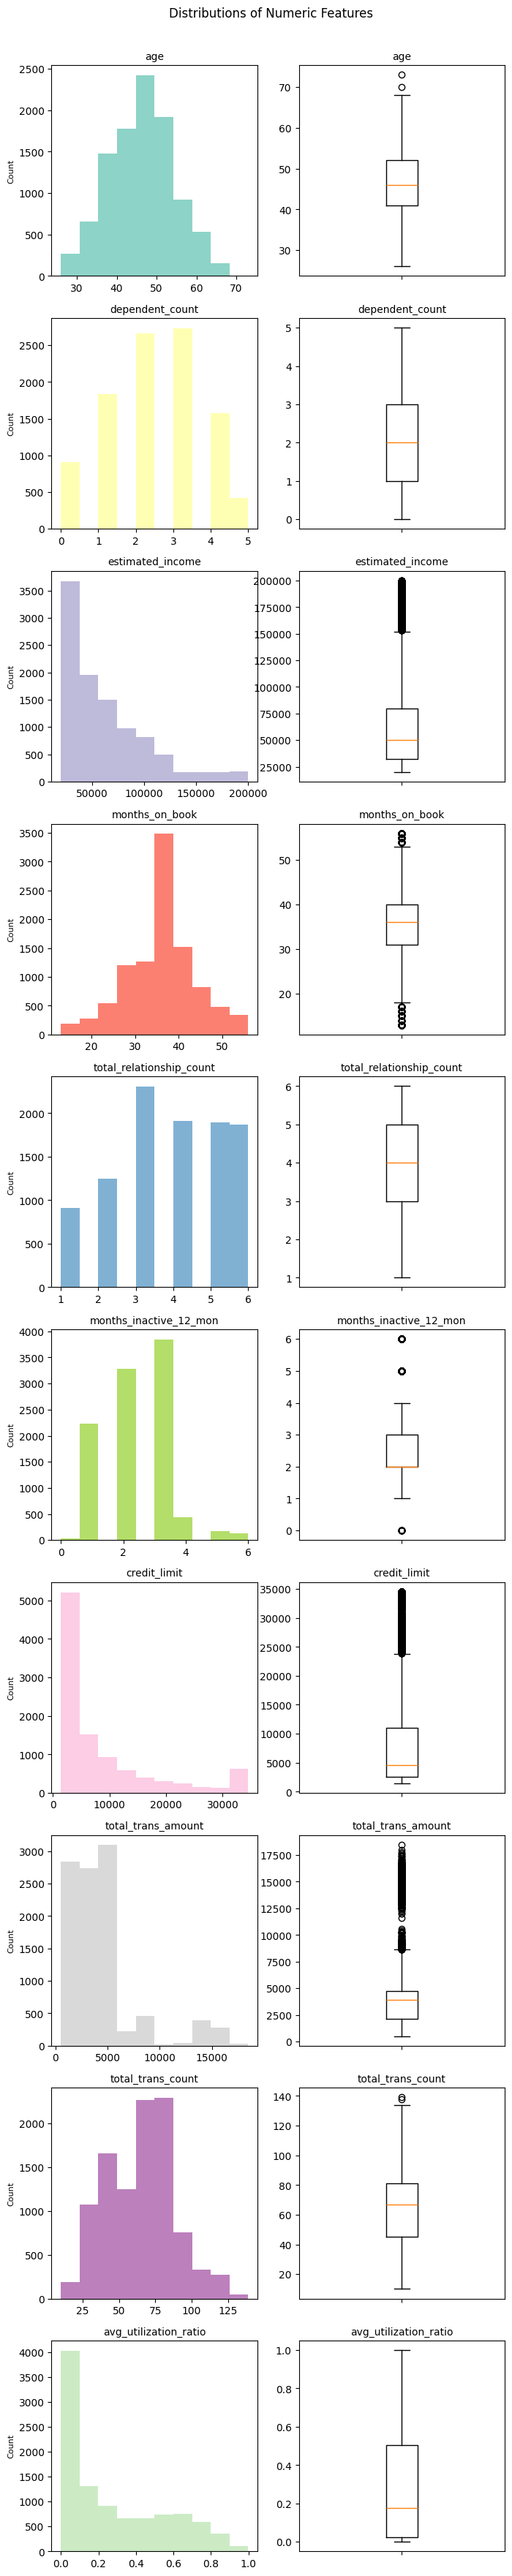

In [7]:
# Distributions
cmap = plt.cm.Set3
colors = [cmap(i) for i in np.linspace(0,1,len(numeric)+1)]
fig, axes = plt.subplots(len(numeric),2, figsize=(8,40))
plt.grid(False)
for i, feature in enumerate(numeric):
    axes[i,0].hist(customers[feature], color=colors[i])
    axes[i,0].set_title(feature, fontsize=10)
    axes[i,0].set_ylabel("Count", fontsize=8)
    axes[i,1].boxplot(customers[feature])
    axes[i,1].set_title(feature, fontsize=10)
    axes[i,1].set_xticklabels([])

title = fig.suptitle("Distributions of Numeric Features")
fig.subplots_adjust(top=.96)
# plt.tight_layout()
plt.show()

* Estimated income, credit limit, total transaction amount, and averge utilization ratio do not resemble a normal distribution.  
* Some features have outliers which may affect the result of segmentation.

## Categorical Features<a id='categorical-features'></a>

In [8]:
# Categorical features
categorical = list(customers.loc[:,(customers.dtypes==object)].columns)
categorical

['gender', 'education_level', 'marital_status']

In [9]:
# Values in categorical features
for c in categorical:
    print(customers[c].value_counts().sort_index())
    print()

gender
F    5358
M    4769
Name: count, dtype: int64

education_level
College          1192
Doctorate         528
Graduate         3685
High School      2351
Post-Graduate     616
Uneducated       1755
Name: count, dtype: int64

marital_status
Divorced     748
Married     4687
Single      3943
Unknown      749
Name: count, dtype: int64



&emsp;The strings values will be converted into numeric values (e.g. 0 for F and 1 for M in gender).

In [10]:
customers_modif = customers.copy()
# gender
customers_modif['gender'] = customers['gender'].apply(lambda x: 0 if x=='F' else 1)
# education_level
def convert_edu(x):
    edus = {"Uneducated": 0,
            "High School": 1,
            "College": 2,
            "Graduate": 3,
            "Post-Graduate": 4,
            "Doctorate": 5}
    return edus[x]
customers_modif['education_level'] = customers['education_level'].apply(convert_edu)
print(customers_modif['education_level'].value_counts().sort_index())

education_level
0    1755
1    2351
2    1192
3    3685
4     616
5     528
Name: count, dtype: int64


&emsp;For marital_status, dummy variables are used due to the nature of its nominal values.

In [11]:
customers_modif = pd.get_dummies(customers_modif, columns=['marital_status'], dtype=int)
customers_modif.head(3)

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,0,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,0,1,0,0


## Standardization<a id='standard'></a>

In [12]:
# Remove customer_id which is not needed for scaling
customers_s = customers_modif.drop(columns=['customer_id'])
# Scale the whole dataset
scale = StandardScaler()
customers_scaled = pd.DataFrame(scale.fit_transform(customers_s), columns=list(customers_s.columns))
customers_scaled.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,-0.282405,1.077338,-0.798507,-0.282609
1,0.333570,-0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.282405,-0.928214,1.252337,-0.282609
2,0.583058,1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
3,-0.789126,-0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.282405,-0.928214,-0.798507,3.538459
4,-0.789126,1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,-0.282405,1.077338,-0.798507,-0.282609


# Model Building<a id='model-build'></a>

&emsp;To find the optimal number of clusters, models with different values of K will be built. An Elbow Curve plot by inertia values will be used to determine the best K value. Note that inertia is the sum of squared distances from each data point to the centroid.

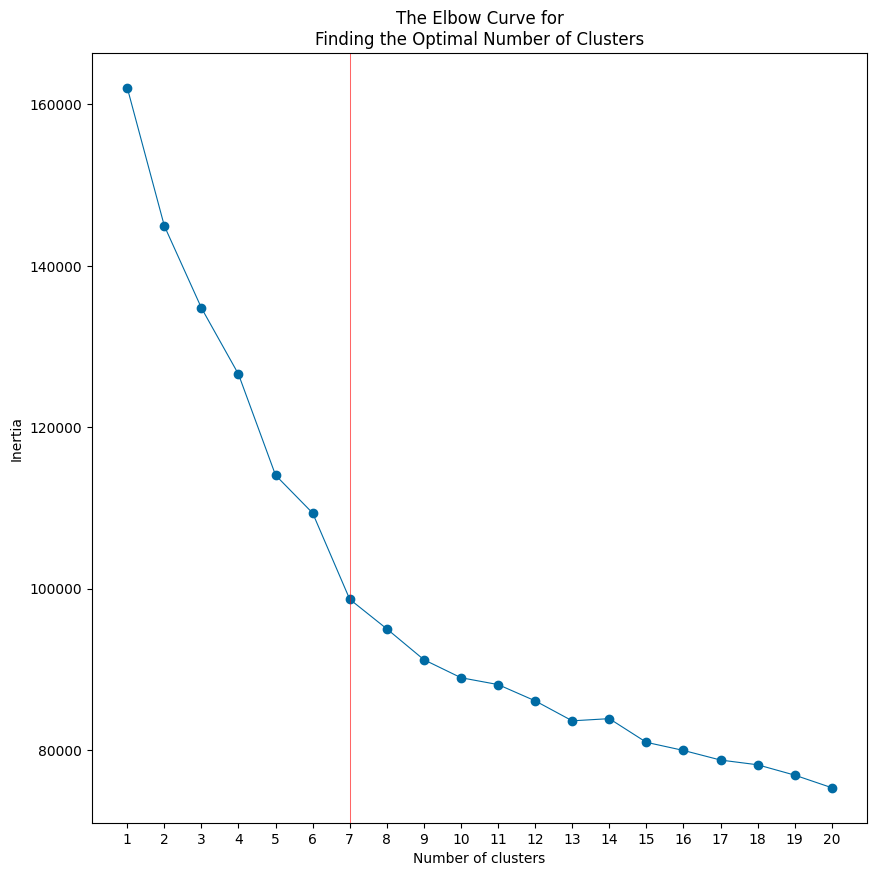

In [13]:
inertias = []
np.random.seed(4)
for k in range(1,21):
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(customers_scaled)
    inertias.append(model.inertia_)

# Plot elbow curve
plt.figure(figsize=(10,10))
plt.plot(range(1,21), inertias, linewidth=.8, marker='o')
plt.xticks(range(1,21))
plt.axvline(7, color='red', alpha=.6, linewidth=.75)
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.title("The Elbow Curve for\nFinding the Optimal Number of Clusters")
plt.show()

&emsp;The decrease in inertia slows down after the number of clusters reaches 7. Thus, model with 7 clusters is used to build the model.

In [14]:
model = KMeans(n_clusters=7)
clusters = model.fit_predict(customers_scaled)
print(clusters)

[4 5 4 ... 0 4 0]


# Result Interpretation<a id='interpret'></a>

In [15]:
# Assign result back to original dataset
customers['CLUSTER'] = clusters+1

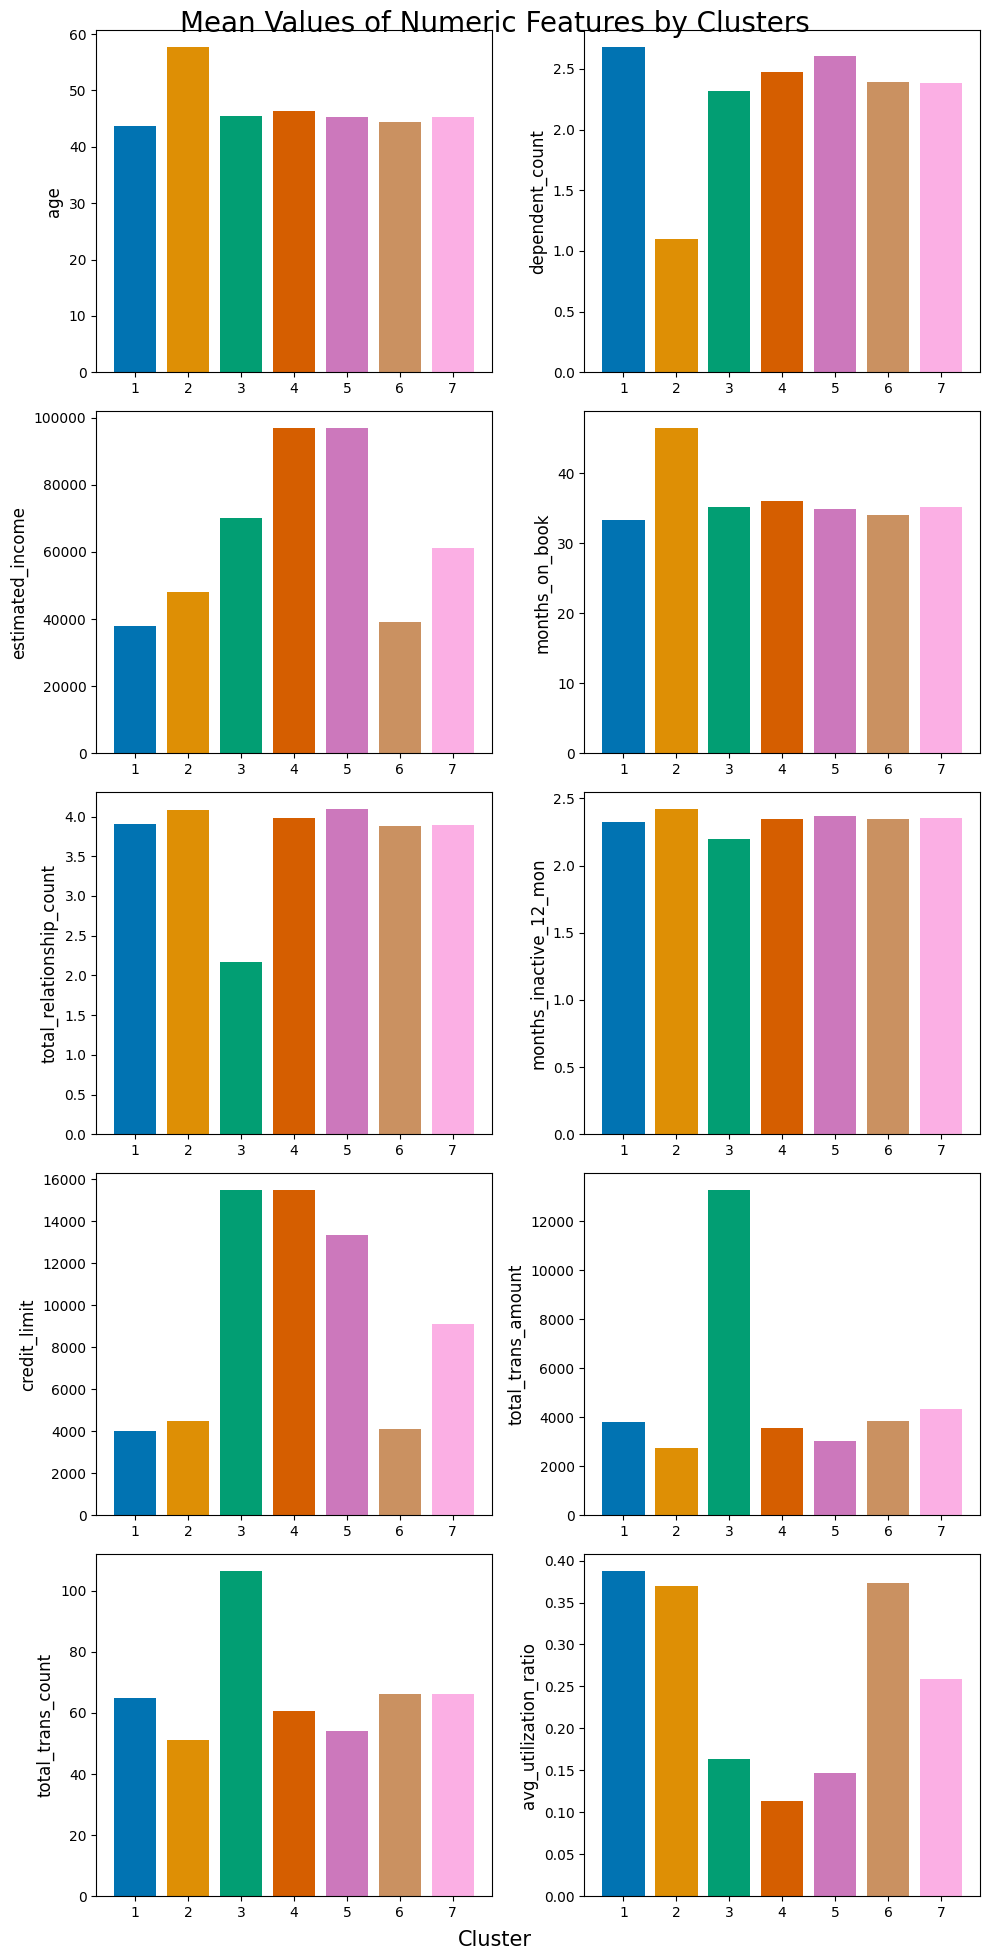

In [16]:
# Numeric features
fig, axes = plt.subplots(5,2, figsize=(10,20))
for i, f in enumerate(numeric):
    groups = customers.groupby("CLUSTER")[f].mean().sort_index()
    axes[i//2,i%2].bar(groups.index, groups, color=sns.color_palette('colorblind'))
    axes[i//2,i%2].set_ylabel(f, fontsize=12)
    axes[i//2,i%2].set_xticks([1,2,3,4,5,6,7])
fig.supxlabel("Cluster", fontsize=15)
title = fig.suptitle("Mean Values of Numeric Features by Clusters", fontsize=20)
fig.subplots_adjust(top=.95)
fig.tight_layout()
plt.show()

* Cluster 2 has relatively bigger age and months on book values while fewer dependents,  
* Clusters 4 & 5 have the most estimated income; however, their total transaction amount or count are almost the lowest among all the clusters,  
* Cluster 3 has smallest total relationship count (number of times contacting the credit card company); however, it has the highest total transaction amount as well as counts.

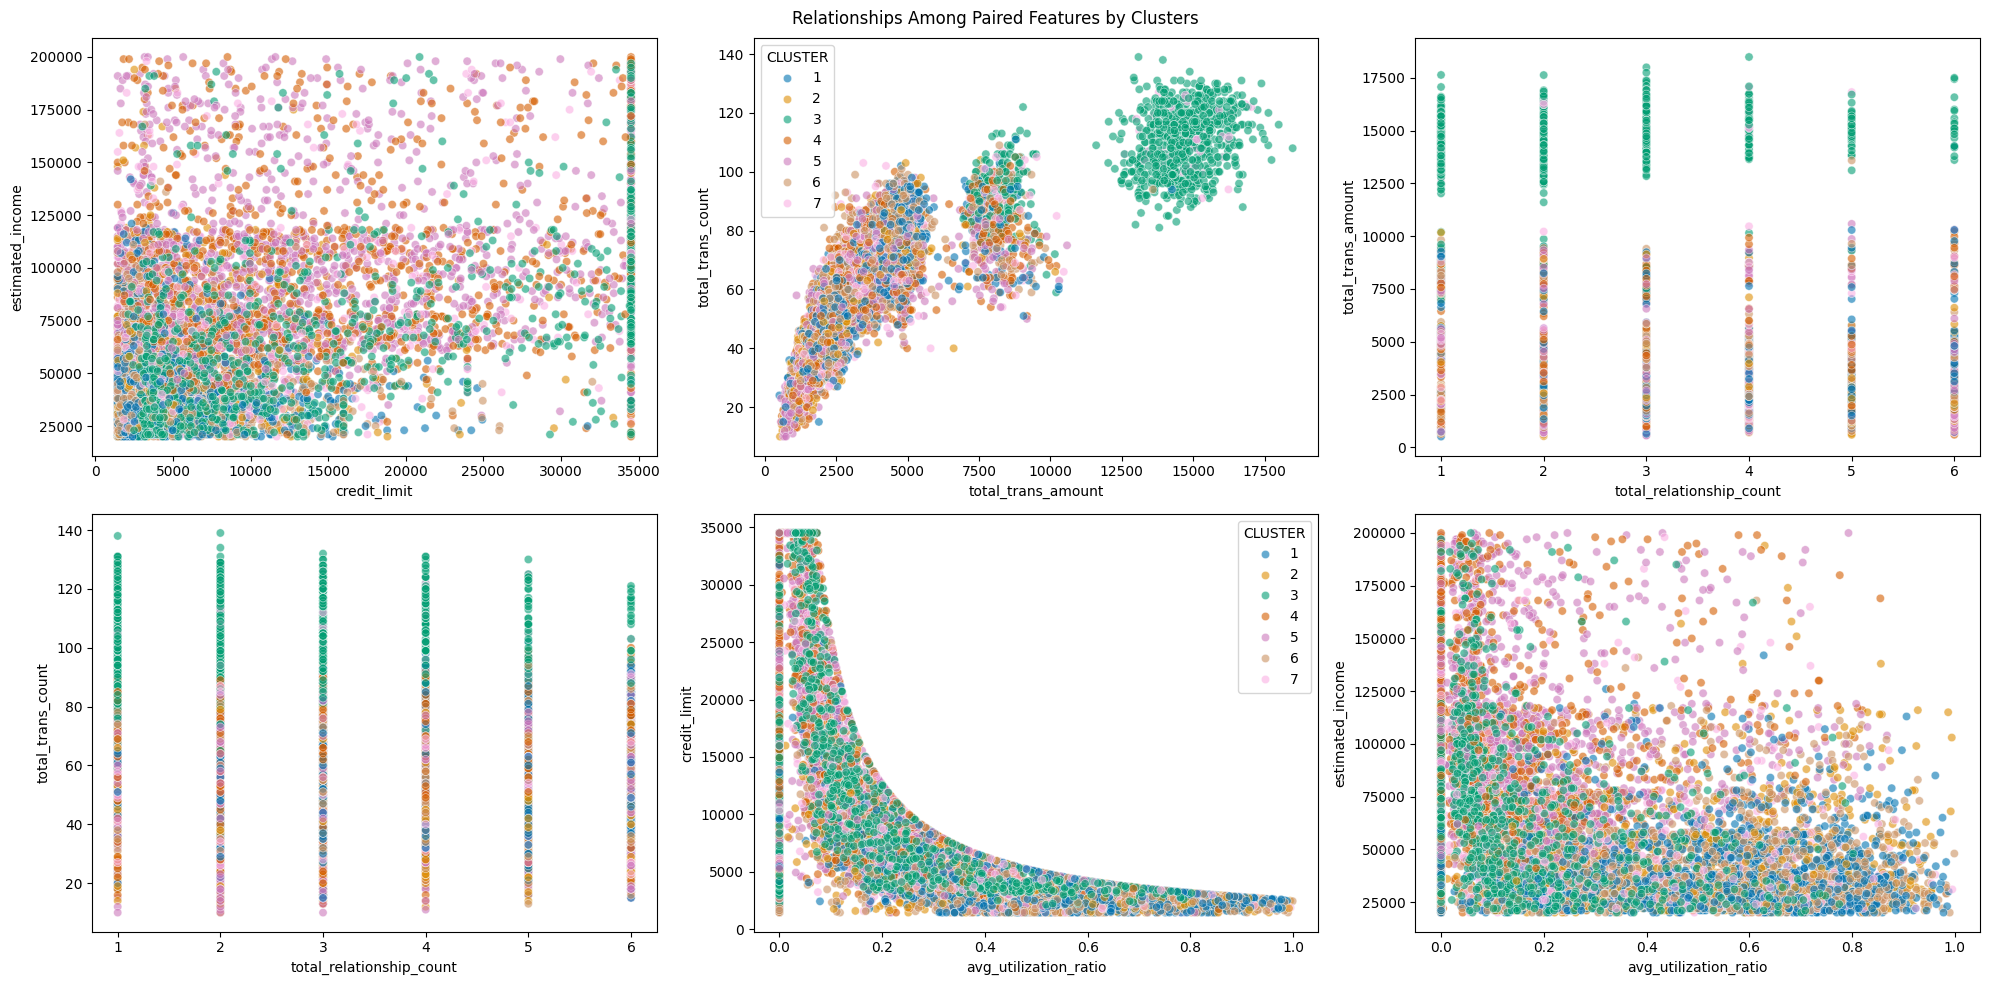

In [17]:
# Scatterplots on Interesting Correlations
fig, axes = plt.subplots(2,3, figsize=(20,10))
# Credit Limit & Estimated Income
sns.scatterplot(data=customers, x='credit_limit', y='estimated_income', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=False, ax=axes[0,0])
# Total Transaction Amount & Total Number of Transaction
sns.scatterplot(data=customers, x='total_trans_amount', y='total_trans_count', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=True, ax=axes[0,1])
# Total Relationship Count & Total Transaction Amount
sns.scatterplot(data=customers, x='total_relationship_count', y='total_trans_amount', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=False, ax=axes[0,2])
# Total Relationship Count & Total Transaction Count
sns.scatterplot(data=customers, x='total_relationship_count', y='total_trans_count', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=False, ax=axes[1,0])
# Credit Limit & Average Utilization Ratio
sns.scatterplot(data=customers, x='avg_utilization_ratio', y='credit_limit', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=True, ax=axes[1,1])
# Estimated Income & Average Utilization Ratio
sns.scatterplot(data=customers, x='avg_utilization_ratio', y='estimated_income', hue='CLUSTER', 
                palette=sns.color_palette('colorblind')[0:7], alpha=.6, legend=False, ax=axes[1,2])

fig.suptitle("Relationships Among Paired Features by Clusters")
fig.tight_layout()
plt.show()

&emsp;It is difficult to draw insights from these scatterplots due to the dense datapoints mixing with numerous  clusters. Only the outstanding cluster 3 shows some characteristics where the customers from this cluster have the greatest total transaction count and at the same time total transaction amount. Also shown in the previous bar charts, customers in this cluster had lower total relationship count generally.

/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_10790/3952756522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cats['CLUSTER'] = clusters+1


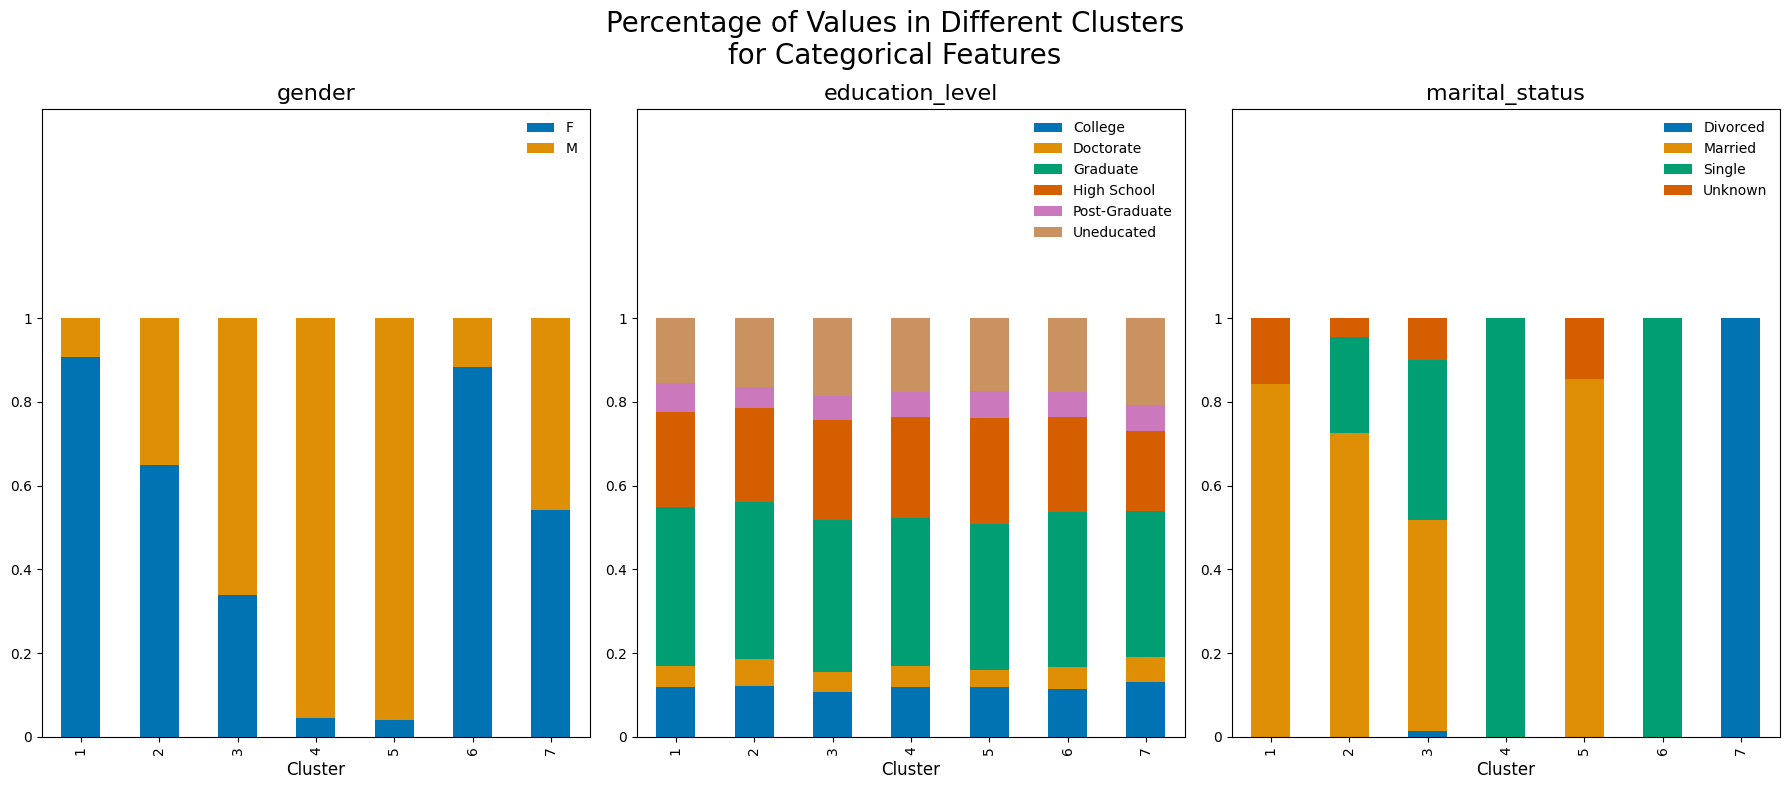

In [18]:
# Stacked bars for categorical features
cats = customers.loc[:,customers.dtypes==object]
cats['CLUSTER'] = clusters+1

# Visualize
fig, axes = plt.subplots(1,3, figsize=(18,8))
for i, cat in enumerate(cats.columns[0:-1]):
    tabs = pd.crosstab(index=cats['CLUSTER'], columns=cats[cat], values=cats[cat], aggfunc='size', normalize='index')
    tabs.plot.bar(stacked=True, ax=axes[i], color=sns.color_palette('colorblind'))
    axes[i].set_title(cat, fontsize=16)
    axes[i].set_ylim(0,1.5)
    axes[i].legend(frameon=False)
    axes[i].set_yticks([0,.2,.4,.6,.8,1])
    axes[i].set_yticklabels([0,.2,.4,.6,.8,1])
    axes[i].set_xlabel("Cluster", fontsize=12)

fig.suptitle("Percentage of Values in Different Clusters\nfor Categorical Features", fontsize=20)
fig.tight_layout()
plt.show()

* The majority of clusters 1 & 6 are females whereas the majority of clusters 4 & 5 are males.  
* All clusters have similar proportions of education levels.  
* Clusters 1 & 5 are mostly married customers.  
* Clusters 4 & 6 are single customers.  
* Approximately all divorced customers are in cluster 7.

# Application<a id='application'></a>

* Cluster 2 may be royal customers who frequently uses their cards but the credit limit is low. Increase credit limit may allow more spending.  
* Clusters 4 & 5 are mainly males who have the greatest estimated income; however, their total transaction amount are just average among all the customers. Promotions tailored for men may induce more spending.  
* Cluster 3 is the only group with apparently smaller number of times contacting the credit card company than other clusters; however, the customers in the cluster spent significantly more than other clusters. One possible reason could be the customers had less complaint about the service. Reasons would be useful to increase and reinforce the satisfaction of customers from other clusters.  
* Clusters 1, 2, and 6 are mostly females with low credit card limits. Promotions tailored for women together with an increase in credit limit may induce more spending.

&emsp;The number of clusters may need to be revised to generate more useful insights from the result. Features such as education level could be removed in the next model building. Outliers may need to be treated or temporarily removed from the data to see if the clustering produces more desirable result.